In [5]:
import os
import sys
sys.path.append(os.path.join('D:', os.sep, 'Users', 'Julien', 'Documents', 'GitHub', 'diploma_thesis', 'cnn'))
import numpy as np
import matplotlib.pyplot as plt
import torch
print(f'Torch version: {torch.__version__}')
from collections import namedtuple
Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")
from datetime import timedelta
from matplotlib.ticker import MultipleLocator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from visualize import plot as plot_cells

Torch version: 1.7.1


# Constants

In [2]:
main_dir = os.path.join("H:", os.sep, "DA_Results", "original_gaea")
seeds = [1124, 2554, 3141, 5520, 7478]
modes = ["search_single_level", "search_bi_level", "eval_bi_level", "eval_single_level", "eval_bi_level_bs_128", "eval_single_level_bs_128"]
metrics = ["train_acc", "valid_acc", "lr"]

def generate_folder_name(mode, seed):
    if "search" in mode:
        dir_name = f"search-pcdarts-eedarts-cifar10-{seed}"
        if "single_level" in mode:
            dir_name += "-single_level"
        return dir_name
    else:
        search_method = "bi_level" if "bi_level" in mode else "single_level"
        bs = f"-{search_method}-bs_128" if "bs_128" in mode else ""
        dir_name = f"evaluation-space-darts-REP_{seed}_{search_method}-cifar10-{seed}{'-single_level' if search_method == 'single_level' and bs == '' else ''}{bs}"
        return dir_name
        

# Paths to log files

In [3]:
logs = {
    mode: {
        seed: os.path.join(main_dir, generate_folder_name(mode, seed), 'log.txt')
        for seed in seeds
    }
    for mode in modes
}
for mode in modes:
    for seed in seeds:
        assert os.path.isfile(logs[mode][seed]), f"Not a file: {logs[mode][seed]}"

# Parse logs

In [4]:
parsed_logs = {
    mode: {
        seed: {
            metric: None
            for metric in metrics
        }
        for seed in seeds
    }
    for mode in modes
}

for mode in modes:
    for seed in seeds:
        with open(logs[mode][seed], 'r') as file:
            content = file.readlines()
        for metric in metrics:
            vals = []
            for line in content:
                if metric == "lr":
                    if "epoch" in line and "lr" in line:
                        vals.append(float(line.split()[5]))
                else:
                    if metric in line:
                        vals.append(float(line.split()[3]))
            if metric == "valid_acc" and len(vals) == 51:
                del vals[50]
            parsed_logs[mode][seed][metric] = np.asarray(vals)

for mode in modes:
    for seed in seeds:
        assert parsed_logs[mode][seed]['lr'].shape == parsed_logs[mode][seed]['train_acc'].shape, f"Diverting shapes: {mode} {seed}"
        if "search" in mode:
            for metric in metrics:
                target = 1 if metric == "valid_acc" and mode == "search_single_level" else 50
                assert parsed_logs[mode][seed][metric].shape[0] == target, f"{mode} {seed} {metric} is {parsed_logs[mode][seed][metric].shape[0]} should be {target}"
        else:
            for metric in metrics:
                assert parsed_logs[mode][seed][metric].shape[0] == 600, f"{mode} {seed} {metric}"

model_parameters = {}
# parse model parameters:
for mode in modes[2:]:
    params = []
    for seed in seeds:
        with open(logs[mode][seed], 'r') as file:
            content = file.readlines()
        for line in content:
            if "Model total parameters" in line:
                params.append(int(line.split()[5]))
                break
                
    model_parameters[mode] = np.asarray(params)

In [17]:
for mode in model_parameters.keys():
    print(mode)
    print(f"Mean: {round(np.mean(model_parameters[mode])/1e6, 2)}")
    print(f"Std : {round(np.std(model_parameters[mode])/1e6, 2)}")

eval_bi_level
Mean: 3.95
Std : 0.38
eval_single_level
Mean: 5.21
Std : 0.13
eval_bi_level_bs_128
Mean: 3.95
Std : 0.38
eval_single_level_bs_128
Mean: 5.21
Std : 0.13


# Get best values

In [25]:
debug = True
best_search = {}
for mode in modes:
    if debug:
        print(mode)
    best_values = []
    for seed in seeds:
        if debug:
            print(f"    {seed}")
        if mode == "search_single_level":
            pos_best = np.argmax(parsed_logs[mode][seed]['train_acc'])
        else:
            pos_best = np.argmax(parsed_logs[mode][seed]['valid_acc'])
            
        train = 100 - parsed_logs[mode][seed]['train_acc'][pos_best]
        if mode == "search_single_level":
            valid = None
        else:
            valid = 100 - parsed_logs[mode][seed]['valid_acc'][pos_best]
            
        if debug:
            print(f"        {pos_best}: {round(valid, 2)if valid is not None else valid}")
            
        best_values.append([train, valid])
    best_search[mode] = np.asarray(best_values)



search_single_level
    1124
        49: None
    2554
        48: None
    3141
        49: None
    5520
        48: None
    7478
        49: None
search_bi_level
    1124
        49: 14.64
    2554
        49: 14.17
    3141
        48: 14.86
    5520
        49: 14.36
    7478
        46: 14.2
eval_bi_level
    1124
        544: 3.0
    2554
        582: 2.97
    3141
        590: 3.39
    5520
        561: 3.41
    7478
        598: 2.99
eval_single_level
    1124
        590: 4.26
    2554
        567: 3.5
    3141
        590: 3.5
    5520
        580: 4.07
    7478
        595: 3.7
eval_bi_level_bs_128
    1124
        583: 3.03
    2554
        599: 2.89
    3141
        543: 3.55
    5520
        558: 3.62
    7478
        589: 3.33
eval_single_level_bs_128
    1124
        566: 4.33
    2554
        552: 4.14
    3141
        593: 3.84
    5520
        584: 4.8
    7478
        585: 4.05


In [ ]:
parsed_logs["eval_bi_level_bs_128"][1124][]

In [20]:
for mode in modes[2:]:
    print(mode)
    print(np.amin(best_search[mode][:, 1]))
    print(np.argmin(best_search[mode][:, 1]))

eval_bi_level
2.9700030000000055
1
eval_single_level
3.500001999999995
1
eval_bi_level_bs_128
2.8900000000000006
1
eval_single_level_bs_128
3.8400000000000034
2


In [159]:
best_search

{'search_single_level': array([[3.5360000000000014, None],
        [3.263999999999996, None],
        [3.263999999999996, None],
        [3.3220000000000027, None],
        [3.1640000000000015, None]], dtype=object),
 'search_bi_level': array([[ 7.24 , 14.636],
        [ 6.668, 14.172],
        [ 7.104, 14.864],
        [ 6.976, 14.356],
        [ 6.976, 14.196]]),
 'eval_bi_level': array([[2.982003, 3.000002],
        [1.784003, 2.970003],
        [3.534003, 3.390003],
        [3.396002, 3.410002],
        [3.144003, 2.990003]]),
 'eval_single_level': array([[8.284003, 4.260003],
        [6.230003, 3.500002],
        [6.972003, 3.500002],
        [8.266002, 4.070003],
        [7.450002, 3.700002]]),
 'eval_bi_level_bs_128': array([[4.418, 3.03 ],
        [3.734, 2.89 ],
        [5.218, 3.55 ],
        [8.008, 3.62 ],
        [5.5  , 3.33 ]]),
 'eval_single_level_bs_128': array([[16.068,  4.33 ],
        [15.614,  4.14 ],
        [18.218,  3.84 ],
        [19.28 ,  4.8  ],
        [17.

In [166]:
print(np.mean(best_search['eval_bi_level'], axis=0))
print(np.std(best_search['eval_bi_level'], axis=0))

[2.9680028 3.1520026]
[0.6223451  0.20282001]


array([3.5360000000000014, 3.263999999999996, 3.263999999999996,
       3.3220000000000027, 3.1640000000000015], dtype=object)

# $\mu$ and $\sigma$ of all modes

In [168]:
for mode in modes:
    print(mode)
    if mode == "search_single_level":
        print(f"    Mean train: {round(np.mean(best_search[mode][:, 0], axis=0), 2)}")
        print(f"    Std train : {round(np.std(best_search[mode][:, 0], axis=0), 2)}")
    else:
        mean = np.mean(best_search[mode], axis=0)
        std = np.std(best_search[mode], axis=0)
        print(f"    Mean train: {round(mean[0], 2)}")
        print(f"    Std train : {round(std[0], 2)}")
        print(f"\n    Mean valid: {round(mean[1], 2)}")
        print(f"    Std valid : {round(std[1], 2)}")

search_single_level
    Mean train: 3.31
    Std train : 0.12
search_bi_level
    Mean train: 6.99
    Std train : 0.19

    Mean valid: 14.44
    Std valid : 0.27
eval_bi_level
    Mean train: 2.97
    Std train : 0.62

    Mean valid: 3.15
    Std valid : 0.2
eval_single_level
    Mean train: 7.44
    Std train : 0.78

    Mean valid: 3.81
    Std valid : 0.31
eval_bi_level_bs_128
    Mean train: 5.38
    Std train : 1.45

    Mean valid: 3.28
    Std valid : 0.28
eval_single_level_bs_128
    Mean train: 17.41
    Std train : 1.37

    Mean valid: 4.23
    Std valid : 0.32


# Process training progressions for plotting $\mu$ and $\sigma$

In [193]:
training_progress = {
    mode: {
        metric: {}
        for metric in metrics[:2]
    }
    for mode in modes
}
for mode in modes:
    for metric in metrics[:2]:
        combined = np.concatenate(
            [[parsed_logs[mode][seed][metric]] for seed in seeds],
            axis=0
        )
        training_progress[mode][metric]['mean'] = np.mean(combined, axis=0)
        training_progress[mode][metric]['std'] = np.std(combined, axis=0)

In [195]:
training_progress["search_single_level"]["train_acc"]

{'mean': array([41.0328, 58.0208, 64.7892, 68.712 , 72.0024, 74.8104, 76.7696,
        78.2832, 79.6064, 80.7272, 81.488 , 82.3796, 83.1044, 83.7296,
        84.3316, 84.7684, 85.2664, 85.778 , 86.1656, 86.6512, 86.9564,
        87.3792, 87.8488, 88.2492, 88.624 , 89.0764, 89.3956, 89.8072,
        90.1184, 90.56  , 90.8696, 91.278 , 91.6108, 92.2236, 92.4456,
        92.92  , 93.254 , 93.6768, 94.1404, 94.4568, 94.83  , 95.1884,
        95.486 , 95.8272, 96.032 , 96.2868, 96.3948, 96.5292, 96.6272,
        96.6436]),
 'std': array([0.50437542, 0.66544493, 0.47415879, 0.38635735, 0.37539824,
        0.46165164, 0.32777407, 0.34212886, 0.16248766, 0.21242448,
        0.24246732, 0.12332331, 0.20216983, 0.140601  , 0.07150273,
        0.13541876, 0.09715472, 0.25891157, 0.22739358, 0.15298941,
        0.11673834, 0.06008794, 0.12032356, 0.10101564, 0.10575443,
        0.13305277, 0.23757912, 0.10375818, 0.20278619, 0.05236793,
        0.12347891, 0.14016562, 0.15730531, 0.10794369, 0.181

# Plots for search phases

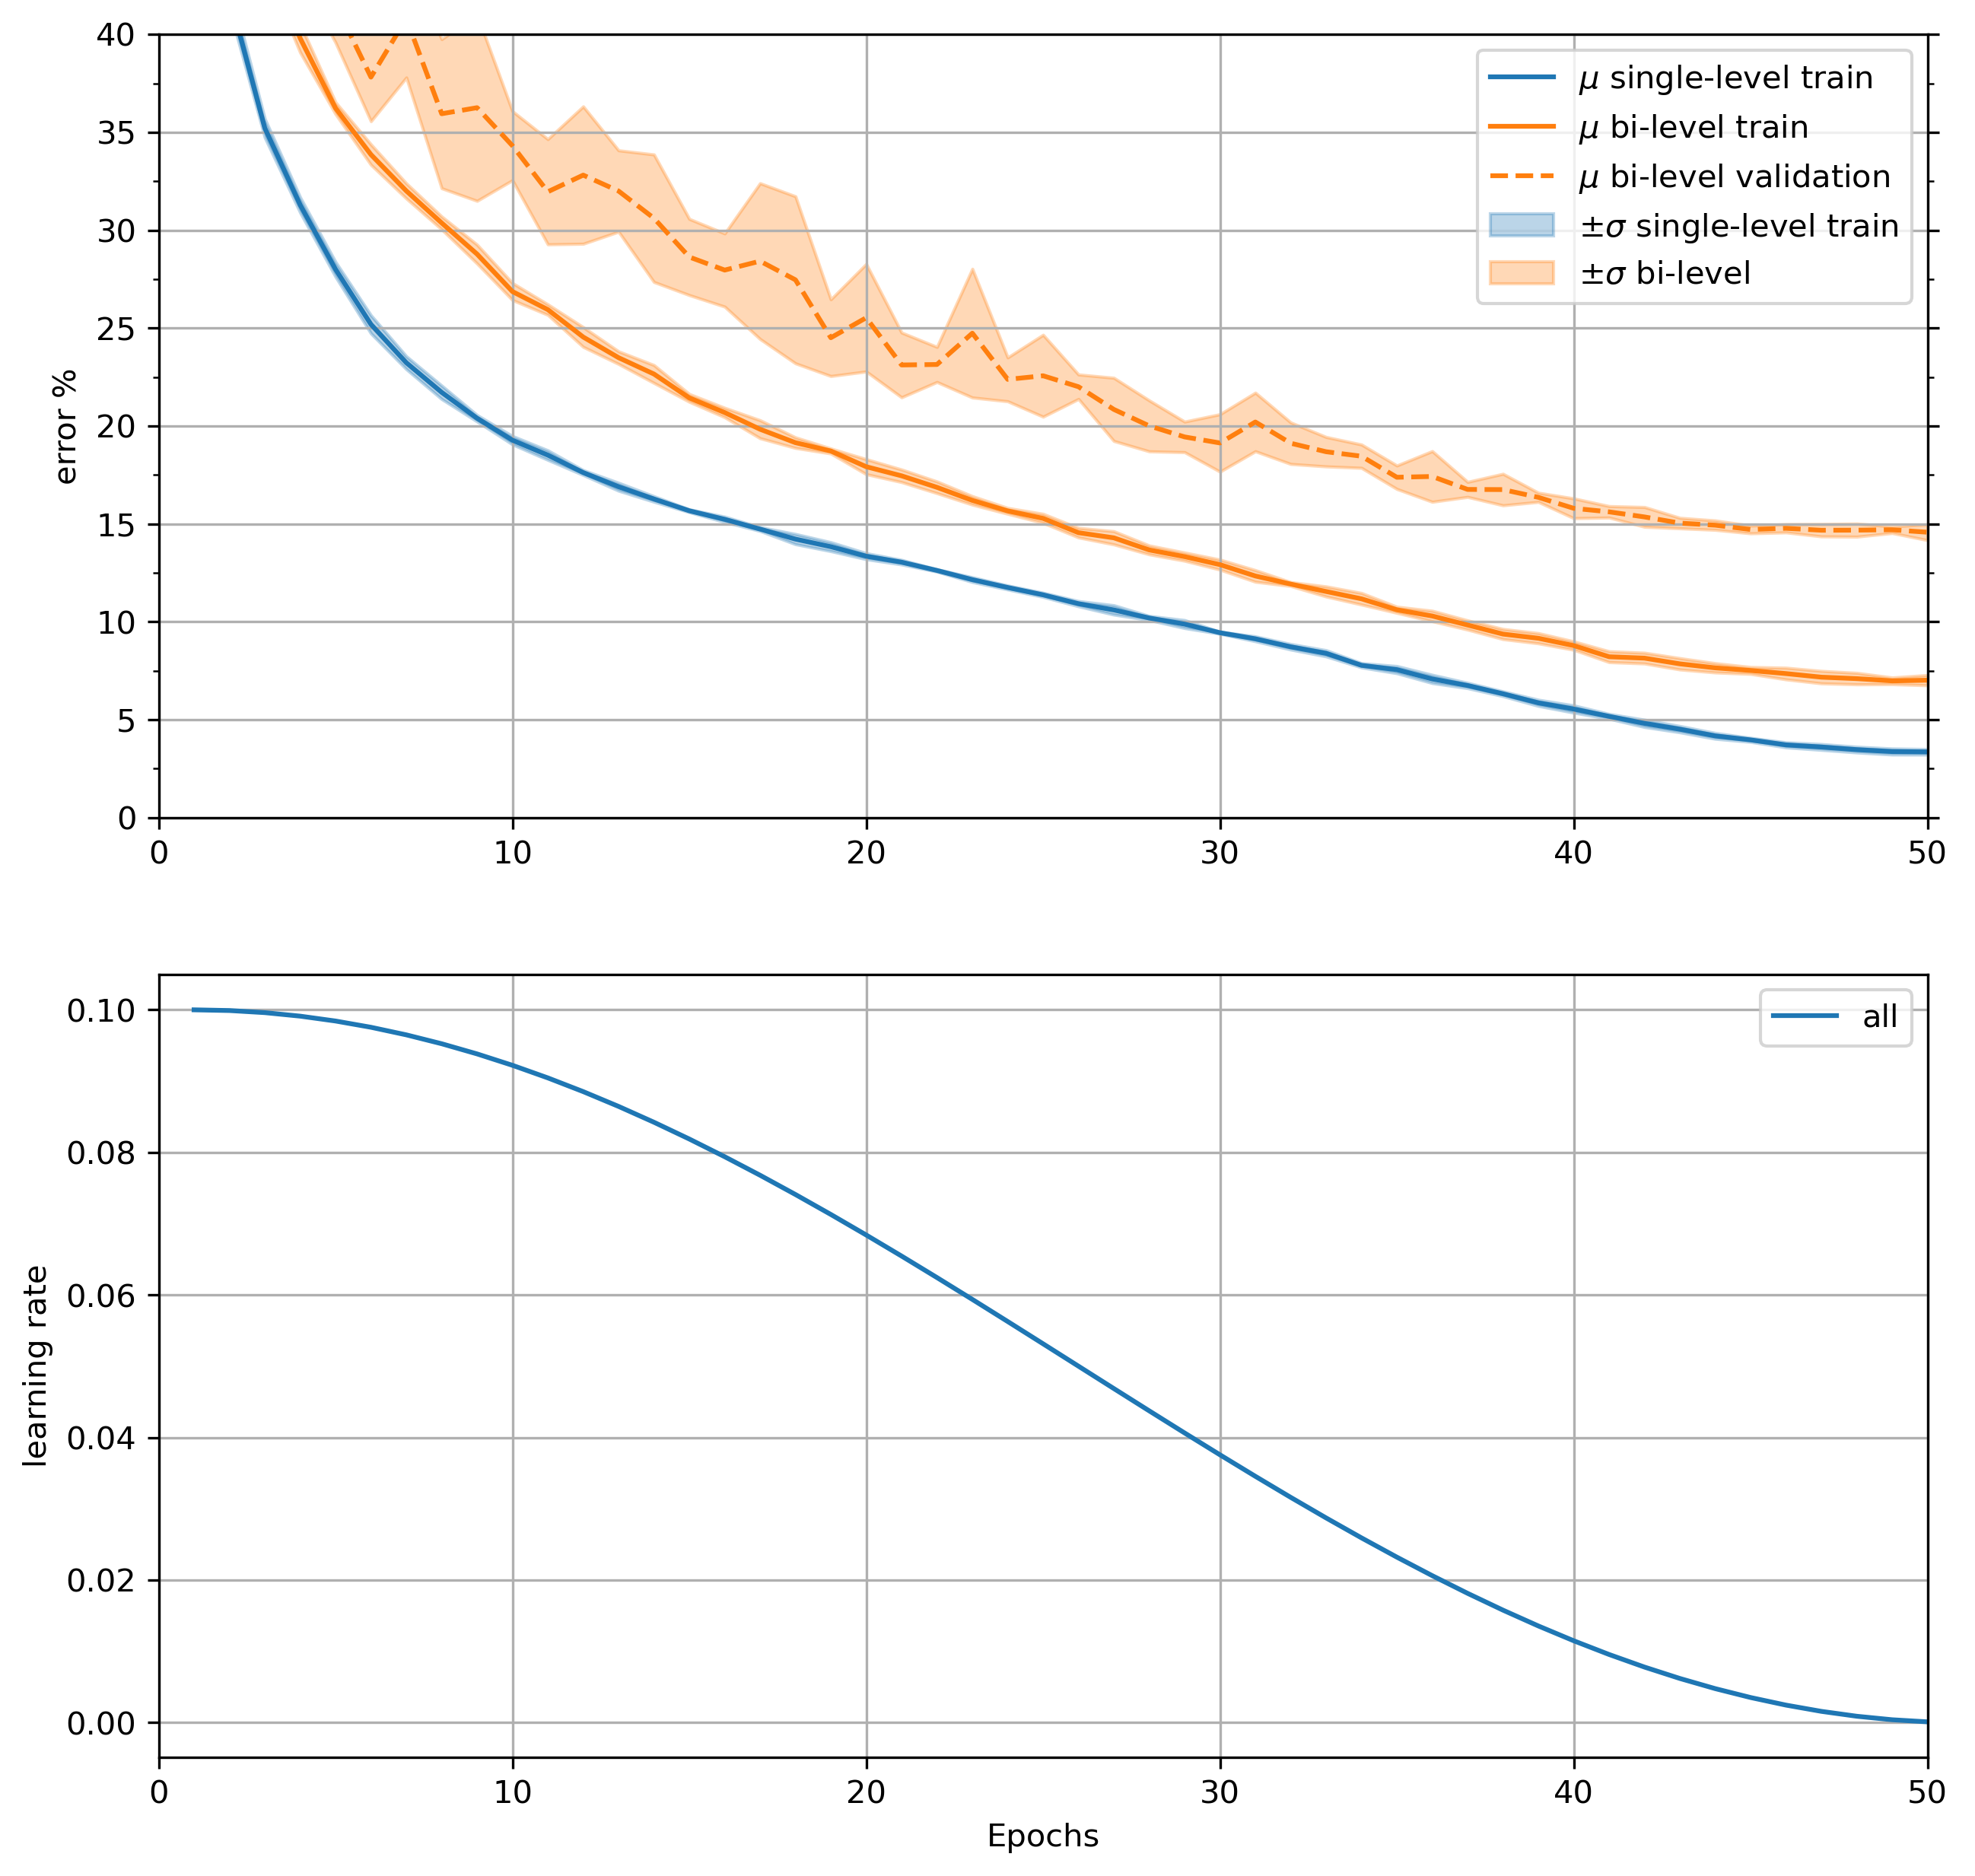

In [294]:
epochs = np.arange(1, training_progress["search_single_level"]["train_acc"]["mean"].shape[0]+1)

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 10), dpi=300)

overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel('Epochs')

error = fig.add_subplot(211)
lr = fig.add_subplot(212)
for ax in fig.get_axes()[1:]:
    ax.grid()
    ax.set_xlim([0, len(epochs)])

error.yaxis.set_ticks_position('both')
error.yaxis.set_minor_locator(MultipleLocator(2.5))
# plot mean single-level train error
error.plot(
    epochs,
    100 - training_progress["search_single_level"]["train_acc"]["mean"],
    color="C0"
)
error.fill_between(
    epochs,
    100 - training_progress["search_single_level"]["train_acc"]["mean"] - training_progress["search_single_level"]["train_acc"]["std"],
    100 - training_progress["search_single_level"]["train_acc"]["mean"] + training_progress["search_single_level"]["train_acc"]["std"],
    alpha=0.3,
    color="C0"
)

# plot mean bi-level train and validation errors
error.plot(
    epochs,
    100 - training_progress["search_bi_level"]['train_acc']["mean"],
    color="C1"
)
error.fill_between(
    epochs,
    100 - training_progress["search_bi_level"]['train_acc']["mean"] - training_progress["search_bi_level"]['train_acc']['std'],
    100 - training_progress["search_bi_level"]['train_acc']["mean"] + training_progress["search_bi_level"]["train_acc"]["std"],
    color="C1",
    alpha=0.3
)
error.plot(
    epochs,
    100 - training_progress["search_bi_level"]['valid_acc']["mean"],
    color="C1",
    linestyle="dashed"
)
error.fill_between(
    epochs,
    100 - training_progress["search_bi_level"]['valid_acc']["mean"] - training_progress["search_bi_level"]["valid_acc"]["std"],
    100 - training_progress["search_bi_level"]['valid_acc']["mean"] + training_progress["search_bi_level"]["valid_acc"]["std"],
    color="C1",
    alpha=0.3
)
error.set_ylabel("error %")

error.legend(
    [
        r"$\mu$ single-level train",
        r"$\mu$ bi-level train",
        r"$\mu$ bi-level validation",
        r"$\pm \sigma$ single-level train",
        r"$\pm \sigma$ bi-level"# train",
        #r"$\sigma$ bi-level validation"
    ]
)

lr.plot(
    epochs,
    parsed_logs["search_single_level"][1124]["lr"]
)
lr.set_ylabel("learning rate")
lr.legend(["all"])

error.set_ylim(bottom=0, top=40)

plt.savefig("images/reproduction_search.svg", bbox_inches="tight")

plt.show()

# Plots for evaluation phases

In [244]:
training_progress.keys()

dict_keys(['search_single_level', 'search_bi_level', 'eval_bi_level', 'eval_single_level', 'eval_bi_level_bs_128', 'eval_single_level_bs_128'])

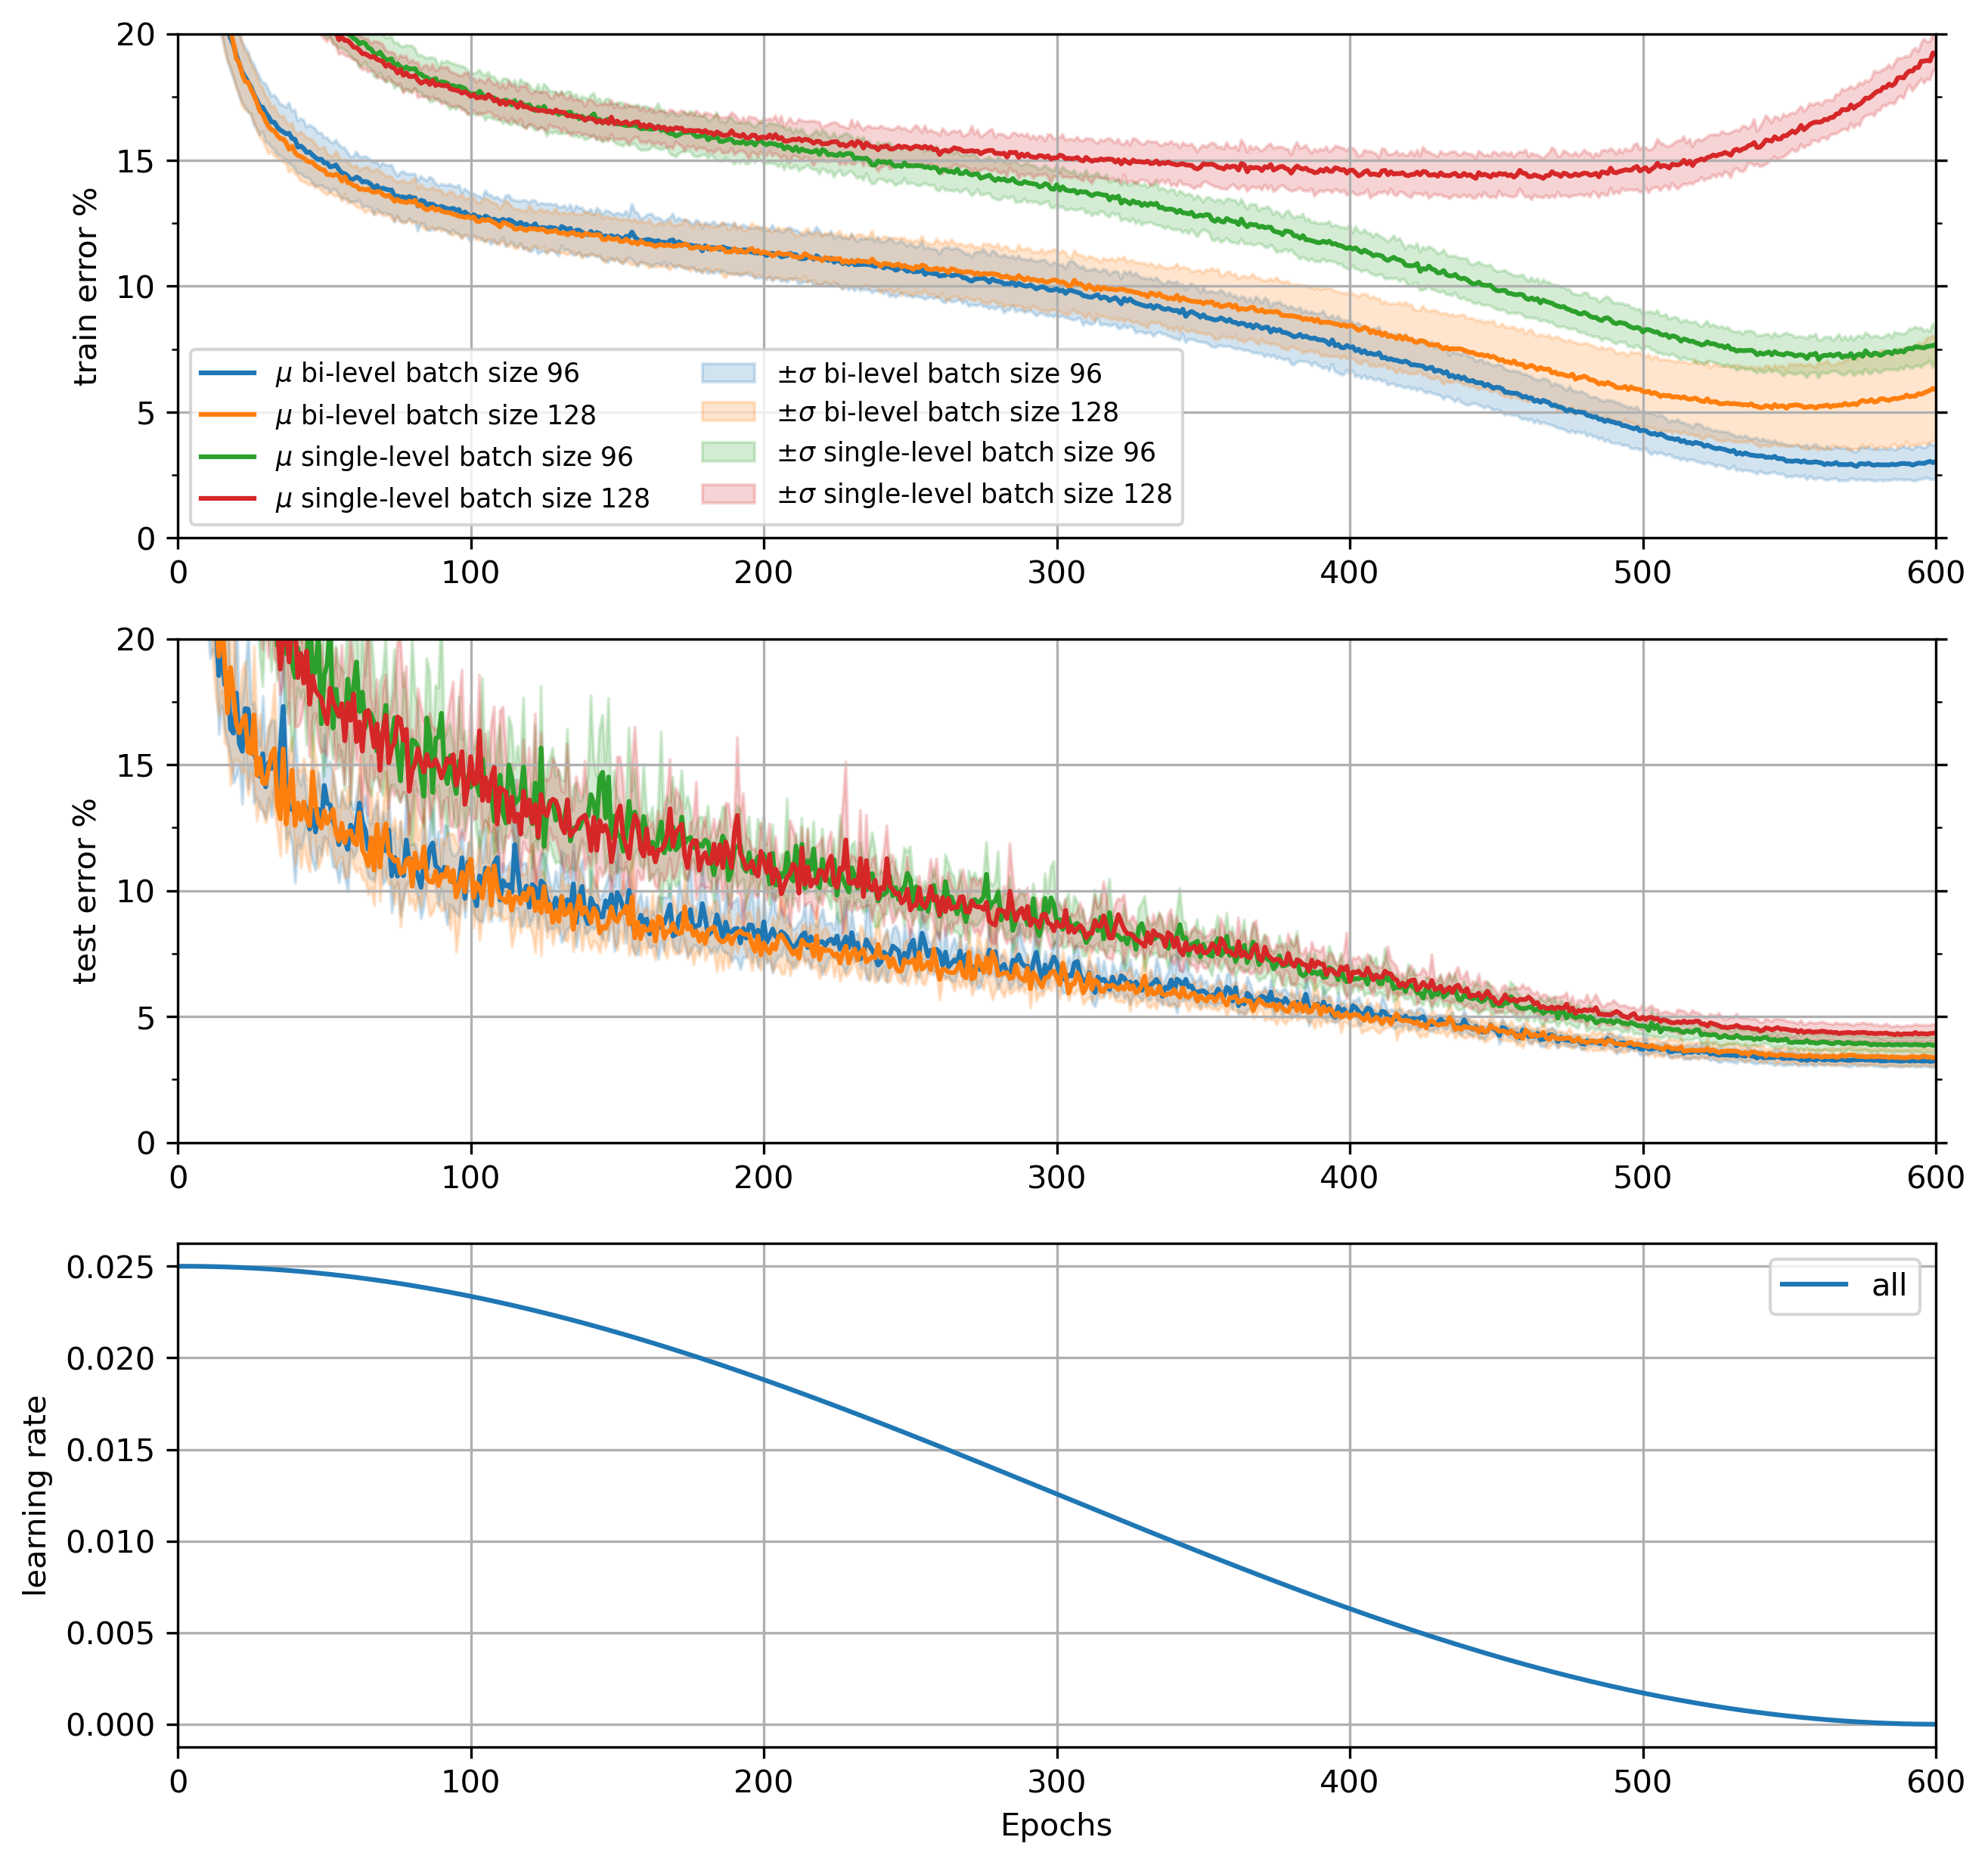

In [293]:
epochs = np.arange(1, training_progress["eval_single_level"]["train_acc"]["mean"].shape[0]+1)
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
fig = plt.figure(figsize=(10, 10), dpi=300)

overall = fig.add_subplot(111)
overall.spines['top'].set_color('none')
overall.spines['bottom'].set_color('none')
overall.spines['left'].set_color('none')
overall.spines['right'].set_color('none')
overall.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
overall.set_xlabel('Epochs')

error_train = fig.add_subplot(311)
error_test = fig.add_subplot(312)
lr = fig.add_subplot(313)
for ax in fig.get_axes()[1:]:
    ax.grid()
    ax.set_xlim([0, len(epochs)])
    
error_train.yaxis.set_ticks_position('both')
error_test.yaxis.set_ticks_position('both')
    
# plot bi-level and single-level train errors
error_train.plot(
    epochs,
    100 - training_progress["eval_bi_level"]["train_acc"]["mean"],
    color="C0"
)
error_train.plot(
    epochs,
    100 - training_progress["eval_bi_level_bs_128"]["train_acc"]["mean"],
    color="C1"
)
error_train.plot(
    epochs,
    100 - training_progress["eval_single_level"]["train_acc"]["mean"],
    color="C2"
)
error_train.plot(
    epochs,
    100 - training_progress["eval_single_level_bs_128"]["train_acc"]["mean"],
    color="C3"
)
error_train.fill_between(
    epochs,
    100 - training_progress["eval_bi_level"]["train_acc"]["mean"] - training_progress["eval_bi_level"]["train_acc"]["std"],
    100 - training_progress["eval_bi_level"]["train_acc"]["mean"] + training_progress["eval_bi_level"]["train_acc"]["std"],
    alpha=0.2,
    color="C0"
)
error_train.fill_between(
    epochs,
    100 - training_progress["eval_bi_level_bs_128"]["train_acc"]["mean"] - training_progress["eval_bi_level_bs_128"]["train_acc"]["std"],
    100 - training_progress["eval_bi_level_bs_128"]["train_acc"]["mean"] + training_progress["eval_bi_level_bs_128"]["train_acc"]["std"],
    alpha=0.2,
    color="C1"
)
error_train.fill_between(
    epochs,
    100 - training_progress["eval_single_level"]["train_acc"]["mean"] - training_progress["eval_single_level"]["train_acc"]["std"],
    100 - training_progress["eval_single_level"]["train_acc"]["mean"] + training_progress["eval_single_level"]["train_acc"]["std"],
    alpha=0.2,
    color="C2"
)
error_train.fill_between(
    epochs,
    100 - training_progress["eval_single_level_bs_128"]["train_acc"]["mean"] - training_progress["eval_single_level_bs_128"]["train_acc"]["std"],
    100 - training_progress["eval_single_level_bs_128"]["train_acc"]["mean"] + training_progress["eval_single_level_bs_128"]["train_acc"]["std"],
    alpha=0.2,
    color="C3"
)
error_train.set_ylabel("train error %")
error_train.legend(
    [
        r"$\mu$ bi-level batch size 96",
        r"$\mu$ bi-level batch size 128",
        r"$\mu$ single-level batch size 96",
        r"$\mu$ single-level batch size 128",
        r"$\pm \sigma$ bi-level batch size 96",
        r"$\pm \sigma$ bi-level batch size 128",
        r"$\pm \sigma$ single-level batch size 96",
        r"$\pm \sigma$ single-level batch size 128"
    ],
    ncol=2,
    fontsize="small"
)

# plot bi-level and single-level test errors
error_test.plot(
    epochs,
    100 - training_progress["eval_bi_level"]["valid_acc"]["mean"],
    color="C0"
)
error_test.plot(
    epochs,
    100 - training_progress["eval_bi_level_bs_128"]["valid_acc"]["mean"],
    color="C1"
)
error_test.plot(
    epochs,
    100 - training_progress["eval_single_level"]["valid_acc"]["mean"],
    color="C2"
)
error_test.plot(
    epochs,
    100 - training_progress["eval_single_level_bs_128"]["valid_acc"]["mean"],
    color="C3"
)
error_test.fill_between(
    epochs,
    100 - training_progress["eval_bi_level"]["valid_acc"]["mean"] - training_progress["eval_bi_level"]["valid_acc"]["std"],
    100 - training_progress["eval_bi_level"]["valid_acc"]["mean"] + training_progress["eval_bi_level"]["valid_acc"]["std"],
    alpha=0.2,
    color="C0"
)
error_test.fill_between(
    epochs,
    100 - training_progress["eval_bi_level_bs_128"]["valid_acc"]["mean"] - training_progress["eval_bi_level_bs_128"]["valid_acc"]["std"],
    100 - training_progress["eval_bi_level_bs_128"]["valid_acc"]["mean"] + training_progress["eval_bi_level_bs_128"]["valid_acc"]["std"],
    alpha=0.2,
    color="C1"
)
error_test.fill_between(
    epochs,
    100 - training_progress["eval_single_level"]["valid_acc"]["mean"] - training_progress["eval_single_level"]["valid_acc"]["std"],
    100 - training_progress["eval_single_level"]["valid_acc"]["mean"] + training_progress["eval_single_level"]["valid_acc"]["std"],
    alpha=0.2,
    color="C2"
)
error_test.fill_between(
    epochs,
    100 - training_progress["eval_single_level_bs_128"]["valid_acc"]["mean"] - training_progress["eval_single_level_bs_128"]["valid_acc"]["std"],
    100 - training_progress["eval_single_level_bs_128"]["valid_acc"]["mean"] + training_progress["eval_single_level_bs_128"]["valid_acc"]["std"],
    alpha=0.2,
    color="C3"
)
error_test.set_ylabel("test error %")

lr.plot(
    epochs,
    parsed_logs["eval_single_level"][1124]['lr']
)
lr.set_ylabel("learning rate")
lr.legend(["all"])

error_train.set_ylim(bottom=0, top=20)
error_test.set_ylim(bottom=0, top=20)
error_train.yaxis.set_minor_locator(MultipleLocator(2.5))
error_test.yaxis.set_minor_locator(MultipleLocator(2.5))

plt.savefig("images/reproduction_evaluation.svg", bbox_inches="tight")

plt.show()

# Visualize searched cells

In [9]:
REP_2554_bi_level = Genotype(
    normal=[('dil_conv_5x5', 1), ('dil_conv_3x3', 0), ('sep_conv_3x3', 1), ('dil_conv_3x3', 2), ('sep_conv_5x5', 1), ('dil_conv_3x3', 3), ('sep_conv_3x3', 2), ('skip_connect', 1)],
    normal_concat=range(2, 6),
    reduce=[('max_pool_3x3', 1), ('dil_conv_5x5', 0), ('skip_connect', 2), ('max_pool_3x3', 1), ('sep_conv_3x3', 3), ('dil_conv_3x3', 2), ('sep_conv_5x5', 4), ('sep_conv_5x5', 2)],
    reduce_concat=range(2, 6)
)
REP_2554_single_level = Genotype(
    normal=[('sep_conv_5x5', 1), ('sep_conv_5x5', 0), ('sep_conv_5x5', 2), ('sep_conv_5x5', 1), ('sep_conv_5x5', 3), ('sep_conv_5x5', 2), ('sep_conv_5x5', 4), ('sep_conv_5x5', 3)],
    normal_concat=range(2, 6),
    reduce=[('max_pool_3x3', 1), ('sep_conv_5x5', 0), ('max_pool_3x3', 2), ('sep_conv_5x5', 0), ('max_pool_3x3', 3), ('max_pool_3x3', 2), ('max_pool_3x3', 4), ('max_pool_3x3', 3)],
    reduce_concat=range(2, 6)
)
plot_cells(
    genotype=REP_2554_bi_level.normal, 
    filename="images/reproduction_bi_level_normal_cell", 
    output_format="svg",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_bi_level.reduce, 
    filename="images/reproduction_bi_level_reduction_cell", 
    output_format="svg",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_single_level.normal, 
    filename="images/reproduction_single_level_normal_cell", 
    output_format="svg",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_single_level.reduce, 
    filename="images/reproduction_single_level_reduction_cell", 
    output_format="svg",
    return_type="render",
    view_render="False"
)


plot_cells(
    genotype=REP_2554_bi_level.normal, 
    filename="images/reproduction_bi_level_normal_cell", 
    output_format="pdf",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_bi_level.reduce, 
    filename="images/reproduction_bi_level_reduction_cell", 
    output_format="pdf",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_single_level.normal, 
    filename="images/reproduction_single_level_normal_cell", 
    output_format="pdf",
    return_type="render",
    view_render="False"
)
plot_cells(
    genotype=REP_2554_single_level.reduce, 
    filename="images/reproduction_single_level_reduction_cell", 
    output_format="pdf",
    return_type="render",
    view_render="False"
)


(dot.exe:20284): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:10800): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:15828): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:4056): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:12156): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:21424): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:19964): Pango-WARNING **: couldn't load font "times Not-Rotated 20", falling back to "Sans Not-Rotated 20", expect ugly output.

(dot.exe:7844): Pango-WARNING **: 

# Get number of parameters for dilated convolution and separable convolution

In [8]:
import torch.nn as nn
class SepConv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(SepConv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(
                C_in,
                C_in,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                groups=C_in,
                bias=False,
            ),
            nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_in, affine=affine),
            nn.ReLU(inplace=False),
            nn.Conv2d(
                C_in,
                C_in,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                groups=C_in,
                bias=False,
            ),
            nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )

    def forward(self, x):
        return self.op(x)

class DilConv(nn.Module):
    def __init__(
        self, C_in, C_out, kernel_size, stride, padding, dilation, affine=True
    ):
        super(DilConv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(
                C_in,
                C_in,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                groups=C_in,
                bias=False,
            ),
            nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )

    def forward(self, x):
        return self.op(x)

In [9]:
#X = np.arange(4, 40, 4)
X = np.asarray([16, 32, 64, 36, 72, 144]) // 4
parameters = {
    channels: {}
    for channels in X
}
for x in X:
    model_sep_5 = SepConv(x, x, 5, 1, 1, affine=False)
    params = sum(param.data.nelement() for param in model_sep_5.parameters())
    parameters[x]["SepConv_5"]= params
    model_sep_3 = SepConv(x, x, 3, 1, 1, affine=False)
    params = sum(param.data.nelement() for param in model_sep_3.parameters())
    parameters[x]["SepConv_3"]= params
    model_dil_3 = DilConv(x, x, 3, 1, 2, 2, affine=False)
    params = sum(param.data.nelement() for param in model_dil_3.parameters())
    parameters[x]["DilConv_3"] = params
    model_dil_5 = DilConv(x, x, 5, 1, 2, 2, affine=False)
    params = sum(param.data.nelement() for param in model_dil_5.parameters())
    parameters[x]["DilConv_5"] = params

In [10]:
for x in X:
    print(
        f"{x} & {parameters[x]['SepConv_3']} & {parameters[x]['SepConv_5']} & {parameters[x]['DilConv_3']} & {parameters[x]['DilConv_5']} \\\\"
    )

4 & 104 & 232 & 52 & 116 \\
8 & 272 & 528 & 136 & 264 \\
16 & 800 & 1312 & 400 & 656 \\
9 & 324 & 612 & 162 & 306 \\
18 & 972 & 1548 & 486 & 774 \\
36 & 3240 & 4392 & 1620 & 2196 \\
